# CCPU Forecasting 

## Import Libraraies 

In [8]:
pip install pandas matplotlib statsmodels scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import time
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [10]:
data = pd.read_csv("Challenge_CPU_prediction/Data/cpu_usage.csv")
data.head(10)

,server_id,Date,Timestamp,service_id,service_description,CPU_percent
0,252705,22-11-2025,22-11-2025 20:30,677,CPU_Usage,0.000433
1,179768,28-10-2025,28-10-2025 14:00,438,CPU_Usage,0.000833
2,252705,11-10-2025,11-10-2025 20:30,677,CPU_Usage,0.000833
3,638939,15-10-2025,15-10-2025 00:30,565,CPU_Usage,0.001250
4,638939,26-9-2025,26-9-2025 08:30,565,CPU_Usage,0.001689
5,187782,9-10-2025,9-10-2025 05:00,2710,CPU_Usage,0.001694
6,179768,12-10-2025,12-10-2025 04:30,438,CPU_Usage,0.001722
7,252944,27-11-2025,27-11-2025 16:00,7087,CPU_Usage,0.001750
8,252705,27-10-2025,27-10-2025 11:00,677,CPU_Usage,0.002167
9,115330,29-11-2025,29-11-2025 05:00,416,CPU_Usage,0.002222


## Wrangling

Legnth data  668087
Length of the model : 668087
Duplication check: 579983
Sample timestamps: Timestamp
2025-11-12 09:30:00    121
2025-11-17 05:30:00    121
2025-11-28 05:00:00    121
2025-11-12 09:00:00    121
2025-11-20 06:00:00    120
Name: count, dtype: int64
Number of servers: 124
data wrangled length  585838
The wrangled dataset is audit‑ready: one row per server per time slot, with all features aligned
Resampling to 30‑minute bins per server


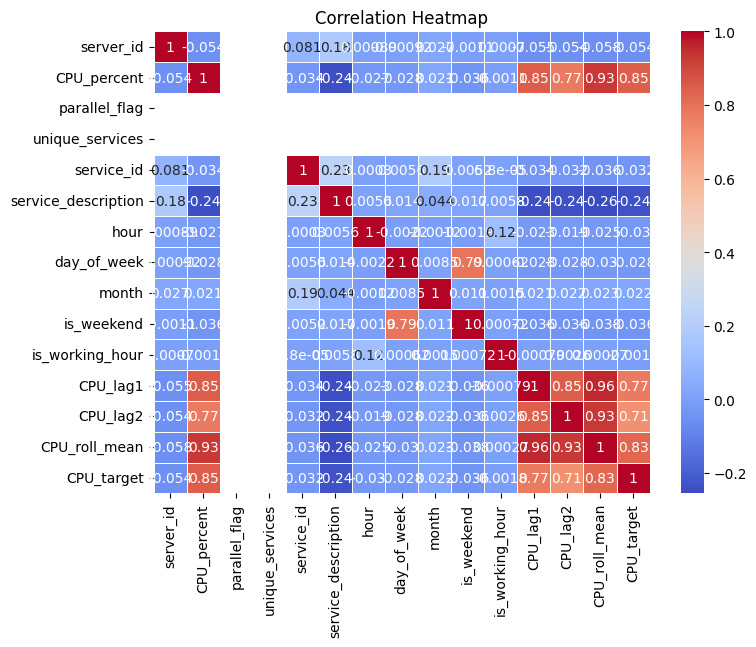

,server_id,Timestamp,CPU_percent,parallel_flag,unique_services,service_id,service_description,hour,day_of_week,month,...,CPU_lag2,CPU_roll_mean,CPU_target,CPU_diff1,CPU_abs_change,CPU_roll_std3,CPU_roll_std5,CPU_spike_flag,hour_service_interaction,parallel_day_interaction
0,100595,2025-07-31 23:30:00,5.469917,0.0,1.0,490.0,1.0,23.0,3.0,7.0,...,2.912083,3.369593,3.837417,0.000000,0.000000,0.000000,0.000000,0,23.0,0.0
1,100595,2025-08-01 00:00:00,3.837417,0.0,1.0,490.0,1.0,0.0,4.0,8.0,...,1.726778,3.678037,1.031250,-1.632500,1.632500,0.000000,0.000000,0,0.0,0.0
2,100595,2025-08-01 00:30:00,1.031250,0.0,1.0,490.0,1.0,0.0,4.0,8.0,...,5.469917,3.446194,3.397611,-2.806167,2.806167,2.245046,0.000000,0,0.0,0.0
3,100595,2025-08-01 01:00:00,3.397611,0.0,1.0,490.0,1.0,1.0,4.0,8.0,...,3.837417,2.755426,3.406528,2.366361,2.366361,1.509286,0.000000,0,1.0,0.0
4,100595,2025-08-01 01:30:00,3.406528,0.0,1.0,490.0,1.0,1.0,4.0,8.0,...,1.031250,2.611796,7.182333,0.008917,0.008917,1.368801,1.587674,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585833,979441,2025-11-30 20:30:00,5.037639,0.0,1.0,2422.0,2.0,20.0,6.0,11.0,...,4.060972,4.939120,3.523333,-0.681111,0.681111,0.833268,0.804893,0,40.0,0.0
585834,979441,2025-11-30 21:00:00,3.523333,0.0,1.0,2422.0,2.0,21.0,6.0,11.0,...,5.718750,4.759907,3.618056,-1.514306,1.514306,1.123750,0.921747,0,42.0,0.0
585835,979441,2025-11-30 21:30:00,3.618056,0.0,1.0,2422.0,2.0,21.0,6.0,11.0,...,5.037639,4.059676,3.370833,0.094722,0.094722,0.848264,0.953974,0,42.0,0.0
585836,979441,2025-11-30 22:00:00,3.370833,0.0,1.0,2422.0,2.0,22.0,6.0,11.0,...,3.523333,3.504074,2.984167,-0.247222,0.247222,0.124731,1.058048,0,44.0,0.0


In [58]:
def Wrangling(df):
    # --- Select relevant columns ---
    data = df[["server_id", "Timestamp", "service_id", "service_description", "CPU_percent"]].copy()
    data["Timestamp"] = pd.to_datetime(data["Timestamp"], dayfirst=True)
    print("Legnth data ", len(data))

    # --- Service counts per server and timestamp ---
    service_counts = (
        data.groupby(["Timestamp", "server_id"])["service_id"]
        .nunique()
        .reset_index(name="unique_services")
    )
    data = data.merge(service_counts, on=["Timestamp", "server_id"], how="left")
    data["parallel_flag"] = (data["unique_services"] > 1).astype(int)

    print(f"Length of the model : {len(data)}")
    # --- Time features ---
    data["hour"] = data["Timestamp"].dt.hour
    data["day_of_week"] = data["Timestamp"].dt.dayofweek
    data["month"] = data["Timestamp"].dt.month
    data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)
    data["is_working_hour"] = data["hour"].between(8, 17).astype(int)

    # --- Season feature ---
    def get_season(month):
        if month in [12, 1, 2]:
            return "Winter"
        elif month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        else:
            return "Autumn"
    data["season"] = data["month"].apply(get_season)

    # --- Map service_description to numeric categories ---
    service_description_mapping = {
        "CPU_Usage": 1,
        "Windows_CPU_Usage": 2,
        "CPU_Usage_SQL": 3
    }
    data["service_description"] = data["service_description"].map(service_description_mapping)

    # --- Resample to 30-min bins per server ---
    data = data.set_index("Timestamp")
    data_30min = (
        data.groupby("server_id")
        .resample("30min")
        .agg({
            "CPU_percent": "mean",
            "parallel_flag": "max",
            "unique_services": "max",
            "service_id": "first",              # keep representative service_id
            "service_description": "first",     # keep representative service_description
            "hour": "first",
            "day_of_week": "first",
            "month": "first",
            "is_weekend": "first",
            "is_working_hour": "first",
            "season": "first"
            
        })
        .reset_index()
    )

    # --- Lag features and rolling stats (per server) ---
    data_30min["CPU_lag1"] = data_30min.groupby("server_id")["CPU_percent"].shift(1)
    data_30min["CPU_lag2"] = data_30min.groupby("server_id")["CPU_percent"].shift(2)
    data_30min["CPU_roll_mean"] = (
        data_30min.groupby("server_id")["CPU_percent"]
        .rolling(3).mean()
        .reset_index(level=0, drop=True)
    )

    # --- Target: next 30-min CPU usage ---
    data_30min["CPU_target"] = data_30min.groupby("server_id")["CPU_percent"].shift(-1)

    # --- Drop rows with missing values in key columns ---
    required_cols = [
        "CPU_percent", "CPU_lag1", "CPU_lag2", "CPU_roll_mean", "CPU_target"
    ]
    data_30min = data_30min.dropna(subset=required_cols)
    
    # Optional: reset index for clean output
    data_30min = data_30min.reset_index(drop=True)
    
    

    # --- Quick checks ---
    print("Duplication check:", data_30min["Timestamp"].duplicated().sum())
    print("Sample timestamps:", data_30min["Timestamp"].value_counts().head())
    print("Number of servers:", data_30min["server_id"].nunique())
# --- Drop rows with missing values in key columns ---
    required_cols = [
        "CPU_percent", "CPU_lag1", "CPU_lag2", "CPU_roll_mean", "CPU_target"
    ]
    data_30min = data_30min.dropna(subset=required_cols)
    
    # Optional: reset index for clean output
    data_30min = data_30min.reset_index(drop=True)
    print("data wrangled length ", len(data_30min))
    data_30min.dropna()
    print("The wrangled dataset is audit‑ready: one row per server per time slot, with all features aligned")
    print("Resampling to 30‑minute bins per server")
    # --- Correlation Heatmap ---
    numeric_data = data_30min.select_dtypes(include=["number"])
    corr = numeric_data.corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

        # --- Volatility & spike features ---
    # Absolute change (short-term volatility)
    data_30min["CPU_diff1"] = data_30min.groupby("server_id")["CPU_percent"].diff(1)
    data_30min["CPU_abs_change"] = data_30min["CPU_diff1"].abs()

    # Rolling standard deviation (local volatility)
    data_30min["CPU_roll_std3"] = (
        data_30min.groupby("server_id")["CPU_percent"]
        .rolling(3).std()
        .reset_index(level=0, drop=True)
    )
    data_30min["CPU_roll_std5"] = (
        data_30min.groupby("server_id")["CPU_percent"]
        .rolling(5).std()
        .reset_index(level=0, drop=True)
    )

    # Spike flag (binary indicator if CPU usage exceeds threshold)
    data_30min["CPU_spike_flag"] = (data_30min["CPU_percent"] > 80).astype(int)

    # --- Interaction features ---
    data_30min["hour_service_interaction"] = data_30min["hour"] * data_30min["service_description"]
    data_30min["parallel_day_interaction"] = data_30min["parallel_flag"] * data_30min["day_of_week"]


    data_30min["CPU_diff1"] = data_30min["CPU_diff1"].fillna(0)
    data_30min["CPU_abs_change"] = data_30min["CPU_abs_change"].fillna(0)
    data_30min["CPU_roll_std3"] = data_30min["CPU_roll_std3"].fillna(0)
    data_30min["CPU_roll_std5"] = data_30min["CPU_roll_std5"].fillna(0)
    

    
    return data_30min

# Example usage
wrangled_data = Wrangling(data)
wrangled_data

## Train/Test Split

In [63]:
features = [
    "CPU_roll_mean", "CPU_lag1", "CPU_lag2",
    "service_description", "hour", "day_of_week",
    "CPU_abs_change", "CPU_roll_std3", "CPU_roll_std5",
    "CPU_spike_flag", "hour_service_interaction", "parallel_day_interaction"
]
target = "CPU_target"

In [64]:
X = wrangled_data[features]
y = wrangled_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Train XGBoost Model

In [65]:
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluate 

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


XGBoost → RMSE: 4.91, MAE: 2.62, R²: 0.61


In [68]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X = wrangled_data[features]
y = wrangled_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


XGBoost → RMSE: 4.91, MAE: 2.62, R²: 0.61


## Feature Importance

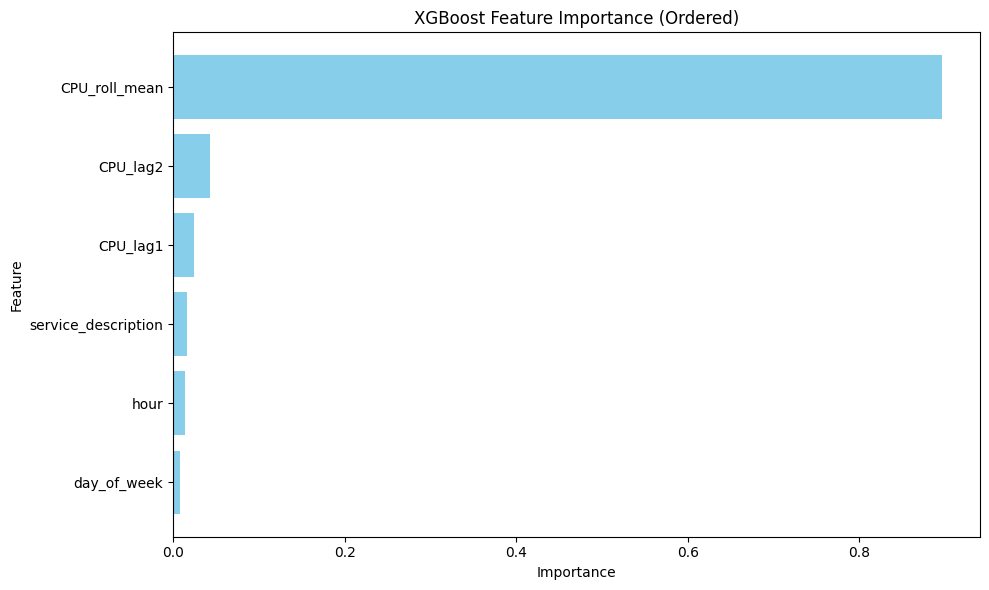

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Create sorted feature importance ---
importance_df = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=True)  # ascending for horizontal barh

# --- Plot ---
plt.figure(figsize=(10,6))
plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
plt.title("XGBoost Feature Importance (Ordered)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [74]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Features and target ---
features = [
    "CPU_roll_mean", "CPU_lag1", "CPU_lag2",
    "service_description", "hour", "day_of_week",
    "CPU_abs_change", "CPU_roll_std3", "CPU_roll_std5",
    "CPU_spike_flag", "hour_service_interaction", "parallel_day_interaction"
]
target = "CPU_target"

X = wrangled_data[features]
y = wrangled_data[target]

# --- Train/test split (time-series style, no shuffle) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Tuned XGBoost model ---
model = XGBRegressor(
    n_estimators=1500,          # more boosting rounds
    max_depth=8,                # deeper trees for complexity
    learning_rate=0.01,         # smaller steps for stability
    subsample=0.8,              # row sampling
    colsample_bytree=0.8,       # feature sampling
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    tree_method="hist",         # efficient histogram-based algorithm
    random_state=42
)

# --- Fit model ---
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost (Tuned) → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


XGBoost (Tuned) → RMSE: 4.91, MAE: 2.62, R²: 0.61


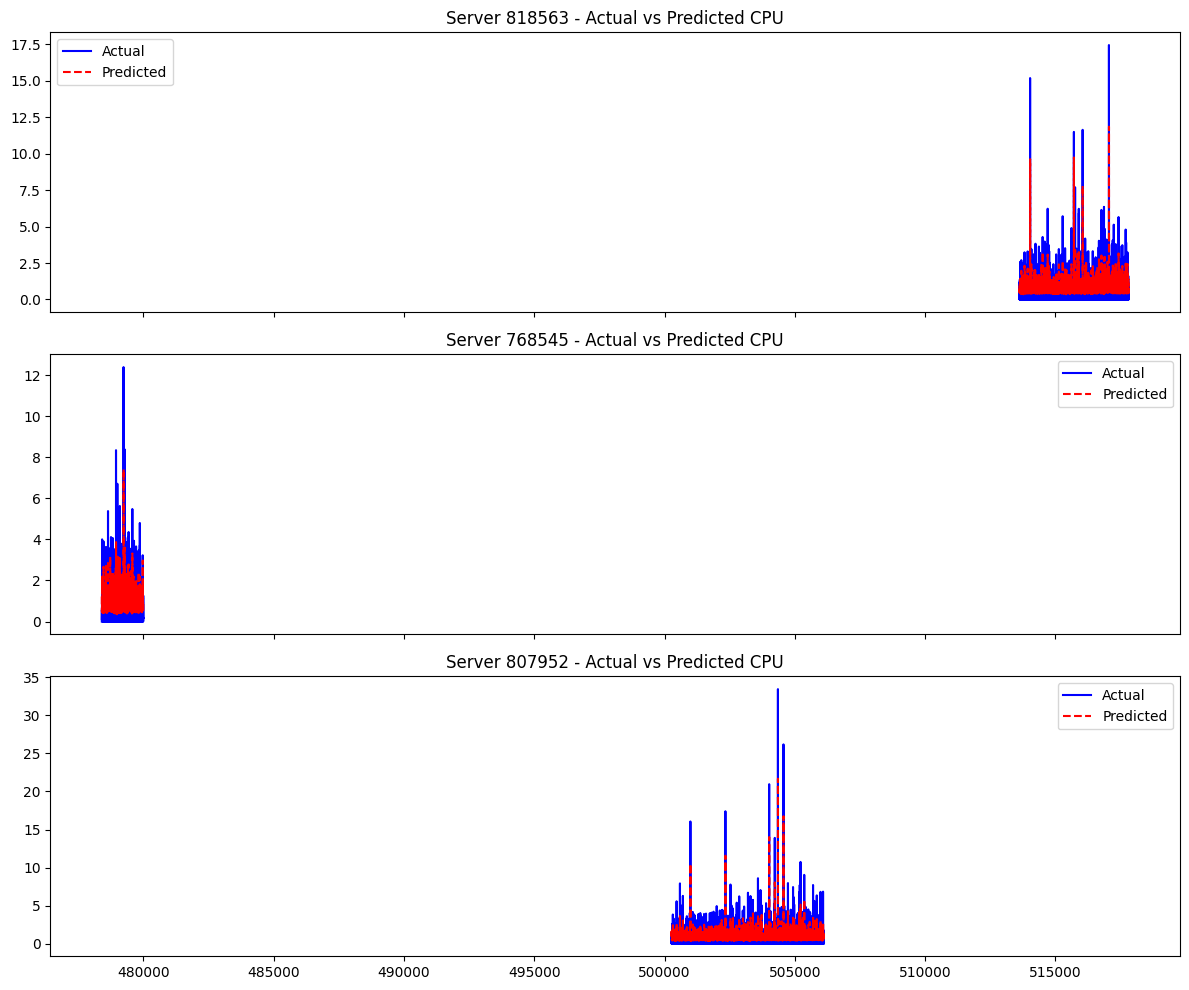

In [41]:

# Assume you already have wrangled_data, model, y_test, y_pred, and server_id column

# --- Per-server error breakdown ---
results = []
for sid in wrangled_data["server_id"].unique():
    mask = wrangled_data["server_id"] == sid
    y_true_sid = y_test[mask]
    y_pred_sid = pd.Series(y_pred, index=y_test.index)[mask]
    if len(y_true_sid) > 0:
        rmse = np.sqrt(mean_squared_error(y_true_sid, y_pred_sid))
        results.append((sid, rmse))

results_df = pd.DataFrame(results, columns=["server_id", "rmse"]).sort_values("rmse")

# --- Select top 3 servers ---
top_servers = results_df.head(3)["server_id"].tolist()

# --- Plot actual vs predicted for top servers ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, sid in enumerate(top_servers):
    mask = wrangled_data["server_id"] == sid
    y_true_sid = y_test[mask]
    y_pred_sid = pd.Series(y_pred, index=y_test.index)[mask]
    
    axes[i].plot(y_true_sid.index, y_true_sid, label="Actual", color="blue")
    axes[i].plot(y_pred_sid.index, y_pred_sid, label="Predicted", color="red", linestyle="--")
    axes[i].set_title(f"Server {sid} - Actual vs Predicted CPU")
    axes[i].legend()

plt.tight_layout()
plt.show()


Residual mean: 0.10843222444214644
Residual std: 4.942506394112872


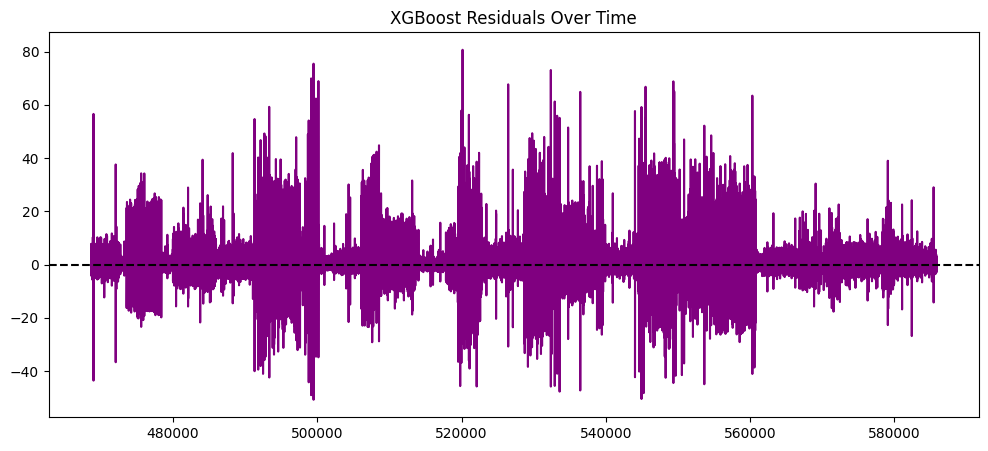

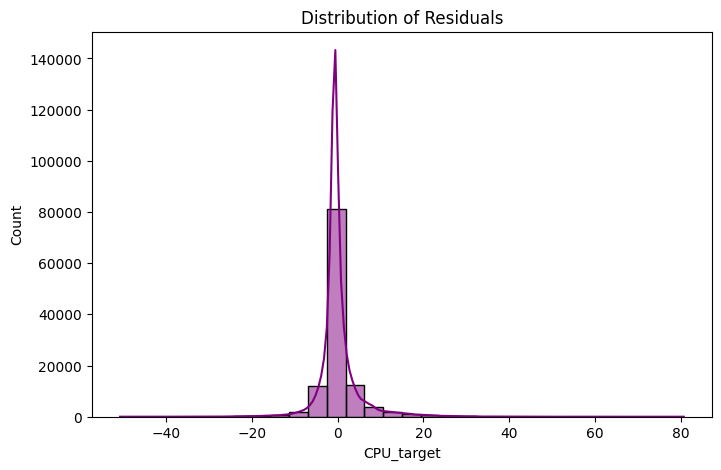

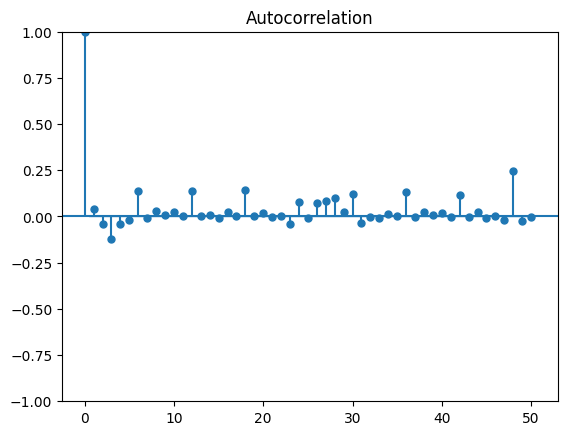

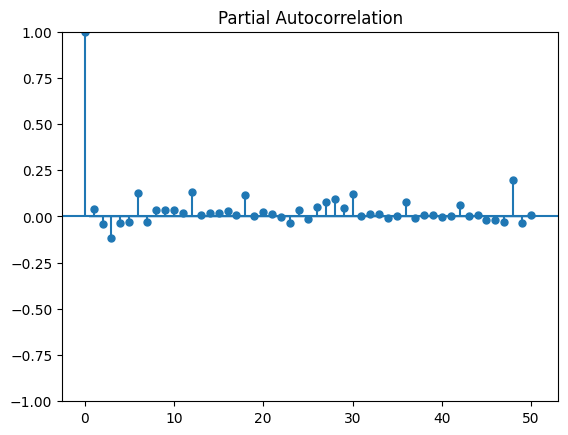

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute residuals ---
residuals = y_test - y_pred

# --- Basic stats ---
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())

# --- Plot residuals over time ---
plt.figure(figsize=(12,5))
plt.plot(y_test.index, residuals, color="purple")
plt.axhline(0, linestyle="--", color="black")
plt.title("XGBoost Residuals Over Time")
plt.show()

# --- Histogram of residuals ---
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Distribution of Residuals")
plt.show()

# --- Autocorrelation check ---
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=50)
plt.show()
plot_pacf(residuals, lags=50)
plt.show()


/Users/mac/Desktop/work-project/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/Users/mac/Desktop/work-project/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/Users/mac/Desktop/work-project/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (Aggregate CPU) → RMSE: 1.24, MAE: 0.89, R²: 0.21


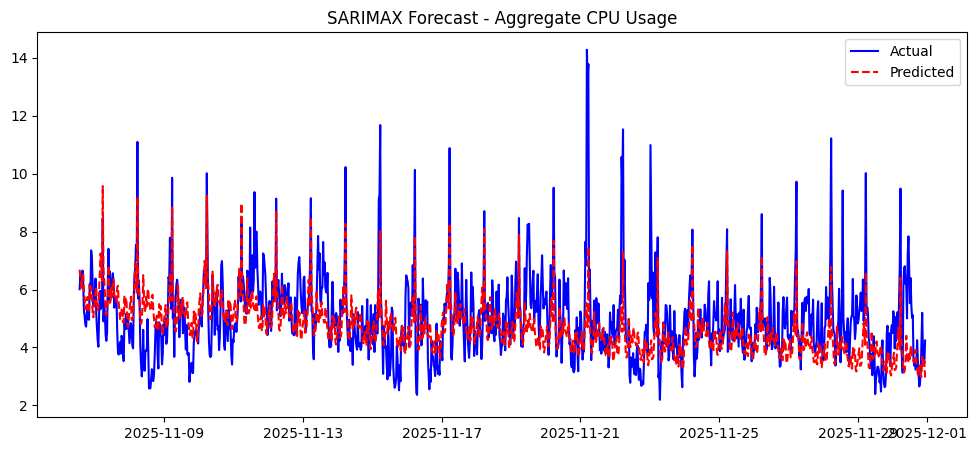

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Aggregate CPU usage across servers ---
agg_data = wrangled_data.groupby("Timestamp")["CPU_percent"].mean()

# --- Exogenous regressors (aggregate calendar features) ---
agg_exog = wrangled_data.groupby("Timestamp")[["hour", "day_of_week"]].first()

# --- Train/test split (80/20) ---
split_idx = int(len(agg_data) * 0.8)
y_train, y_test = agg_data.iloc[:split_idx], agg_data.iloc[split_idx:]
exog_train, exog_test = agg_exog.iloc[:split_idx], agg_exog.iloc[split_idx:]

# --- Fit SARIMAX model ---
model = SARIMAX(y_train,
                exog=exog_train,
                order=(2,0,2),              # ARMA(2,2) structure
                seasonal_order=(1,0,1,48))  # daily seasonality (48 bins of 30min = 1 day)
results = model.fit(disp=False)

# --- Forecast ---
y_pred = results.predict(start=split_idx, end=len(agg_data)-1, exog=exog_test)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"SARIMAX (Aggregate CPU) → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="--")
plt.title("SARIMAX Forecast - Aggregate CPU Usage")
plt.legend()
plt.show()


## Visualisations 

In [147]:
def Visualisations(df):
    # 1. Select a sample server (first one in the dataset)
    sample_server_id = 498343
    sample_df = wrangled_data[wrangled_data["server_id"] == sample_server_id].copy()
    
    # 2. Plot CPU% over time for that server
    # Sort by Timestamp to ensure smooth line
    sample_df = sample_df.sort_values("Timestamp")
    
    # Plot CPU% over time as a proper line chart
    plt.figure(figsize=(12,6))
    plt.plot(sample_df["Timestamp"], sample_df["CPU_percent"], color="blue", linewidth=1)
    plt.title(f"CPU Usage Over Time for Server {sample_server_id}")
    plt.xlabel("Time")
    plt.ylabel("CPU_percent")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # 3. Compute daily profile (30-min slots)
    sample_df["slot"] = sample_df["Timestamp"].dt.hour * 2 + (sample_df["Timestamp"].dt.minute // 30)
    
    daily_profile = sample_df.groupby("slot")["CPU_percent"].mean().reset_index()
    
    # 4. Plot daily profile=--
    plt.figure(figsize=(12,6))
    plt.plot(daily_profile["slot"], daily_profile["CPU_percent"], marker="o")
    plt.title(f"Daily CPU Usage Profile (30-min slots) for Server {sample_server_id}")
    plt.xlabel("Slot (0–47)")
    plt.ylabel("Average CPU_percent")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Visualisations(wrangled_data)


KeyError: 'server_id'